Import Dependencies

In [1]:
import os
import time
import sys
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
from core.raft import RAFT
from core.utils import flow_viz
from core.utils.utils import InputPadder

ImportError: DLL load failed while importing cv2: The specified module could not be found.

In [4]:
print("Is torch.cuda Available? ", torch.cuda.is_available())
print("Device Count: ",torch.cuda.device_count())
print("Current Device: ", torch.cuda.device(torch.cuda.current_device()))
print("Device Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

Is torch.cuda Available?  False
Device Count:  0


AssertionError: Torch not compiled with CUDA enabled

Add RAFT/core to path

In [2]:
sys.path.append('RAFT/core')

Define Helper Functions

In [10]:
def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(
        weights_path, map_location=torch.device("cuda")) # Change to cuda if available
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda") # Change to cuda if available
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel', iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
            flow_low, flow_up = model(frame1, frame2, iters=iters, flow_init=flow_init, upsample=upsample, test_mode=test_mode)
            return flow_low, flow_up

        else:
            flow_iters = model(frame1, frame2, iters=iters, flow_init=flow_init, upsample=upsample, test_mode=test_mode)
            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
    def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
        self.model = model
        self.path = path
        self.small = small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr

    """ Sketchy hack to pretend to iterate through the class objects """

    def __iter__(self):
        return self

    def __next__(self):
        raise StopIteration

Load Model

In [11]:
model = load_model("models/raft-sintel.pth", args=Args())

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Load Images

In [5]:
frame1 = cv2.imread('Test_Leaf_Obstacle_Frame_2.png')
frame2 = cv2.imread('Test_Leaf_Obstacle_Frame_3.png')

# Convert images to rgb color space
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

print(frame1.shape)
print(frame2.shape)

# Resize the second image to match the dimensions of the first image
height, width, channels = frame2.shape
frame1 = cv2.resize(frame1, (width, height))
print(frame1.shape)
print(frame2.shape)

(766, 1020, 3)
(766, 1020, 3)
(766, 1020, 3)
(766, 1020, 3)


Run RAFT Model on Images

In [7]:
time1 = time.perf_counter()
flow_iters = inference(model, frame1, frame2, device='cuda', iters=20, test_mode=False)
time2 = time.perf_counter()
print("Inference Time: ", time2 - time1)
print("Flow Iterations List Size", len(flow_iters))

AssertionError: Torch not compiled with CUDA enabled

Visualizing Model Inference for Optical Flow

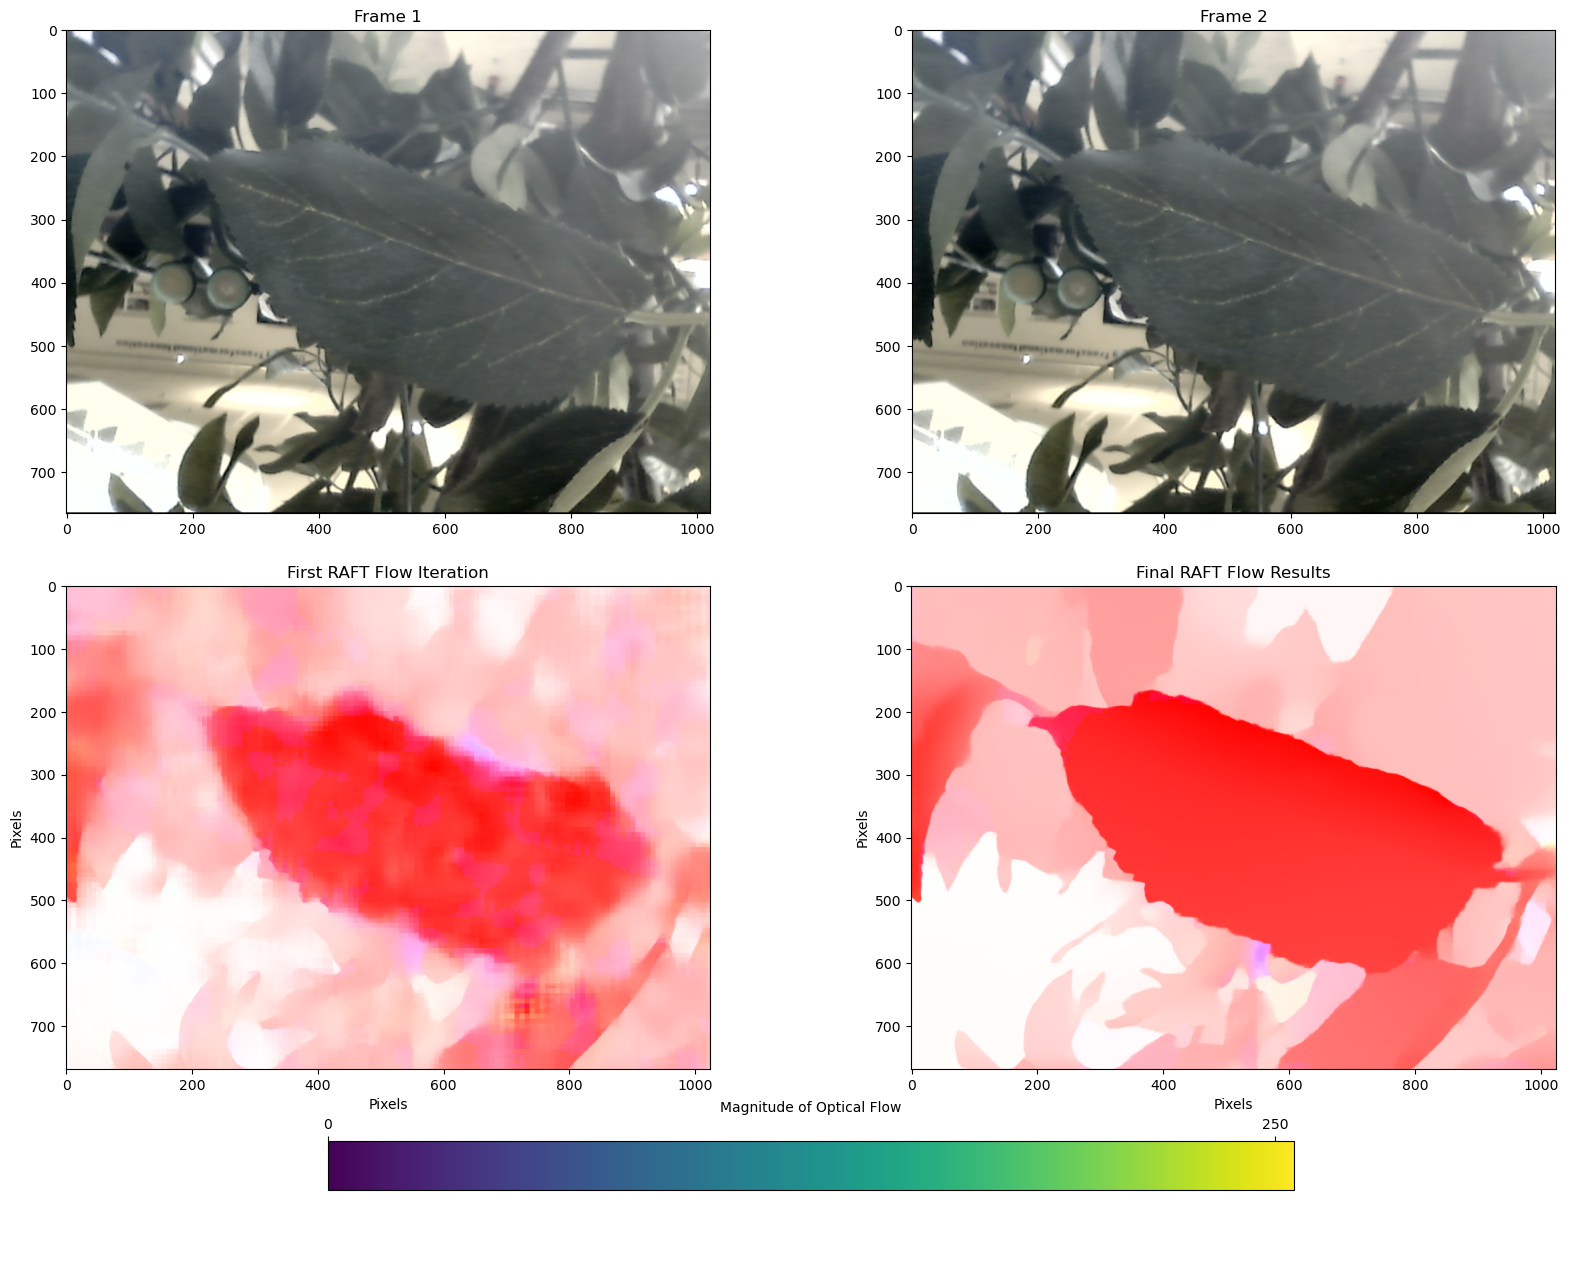

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), gridspec_kw={'height_ratios': [4, 4, 1]})
axes[0, 0].imshow(frame1)
axes[0, 0].set_title("Frame 1")
axes[0, 1].imshow(frame2)
axes[0, 1].set_title("Frame 2")

im0 = axes[1, 0].imshow(get_viz(flow_iters[0]))
axes[1, 0].set_title('First RAFT Flow Iteration')
axes[1, 0].set_xlabel("Pixels"); axes[1, 0].set_ylabel("Pixels")
im1 = axes[1, 1].imshow(get_viz(flow_iters[-1]))
axes[1, 1].set_title('Final RAFT Flow Results')
axes[1, 1].set_xlabel("Pixels"); axes[1, 1].set_ylabel("Pixels")

# Add color bars
axes[2, 0].axis('off')
axes[2, 1].axis('off')
cbar0 = fig.colorbar(im0, ax=axes[2, :], fraction=0.4, pad=0.04, location="top")
cbar0.set_label('Magnitude of Optical Flow')
cbar0.set_ticks([0, 250])

# Adjust layout to ensure all plots and color bars are visible
# plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

Final Iteration Flow Analysis

In [33]:
final_flow = flow_iters[-1]
print("Final Flow Tensor Shape: ", final_flow.shape)
flow_x_matrix = final_flow[0, 0]  # Horizontal displacement component
flow_y_matrix = final_flow[0, 1]  # Vertical displacement component

# Compute the magnitude of flow
flow_magnitude = torch.sqrt(flow_x_matrix**2 + flow_y_matrix**2)

# Clone, detach, and set requires_grad to True for gradient calculation
flow_x_matrix_1 = flow_x_matrix.clone().detach().requires_grad_(True)  
flow_y_matrix_1 = flow_y_matrix.clone().detach().requires_grad_(True)

# Now compute the gradient of the flow magnitude with respect to the initial frame
gradient_x = torch.autograd.grad(outputs=flow_magnitude, inputs=flow_x_matrix_1, retain_graph=True)[0]
gradient_y = torch.autograd.grad(outputs=flow_magnitude, inputs=flow_y_matrix_1)[0]

# Convert gradient tensors to strings before writing to file
gradient_x_str = str(gradient_x.numpy().tolist())
gradient_y_str = str(gradient_y.numpy().tolist())
print(gradient_x.shape)

with open('gradient_x.txt', 'w') as fp_x:
    fp_x.write(gradient_x_str)

with open('gradient_y.txt', 'w') as fp_y:
    fp_y.write(gradient_y_str)


Final Flow Tensor Shape:  torch.Size([1, 2, 768, 1024])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn